In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import collections
from sklearn import model_selection
import math
import os

from losses import triplet_hard_loss, triplet_semihard_loss
from model import create_model
from generator import create_dataset
from optimizer import get_optimizer
from util import read_data
from config import config

gpus = tf.config.experimental.list_physical_devices('GPU')
num_gpus = len(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(num_gpus, "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

1 Physical GPUs, 1 Logical GPUs
Compute dtype: float16
Variable dtype: float32


In [2]:
dataframe = read_data(input_path=config['input_path'])
print('data shape =', dataframe.shape)
dataframe.head(5)

data shape = (81313, 2)


,landmark_id,path
0,1,../input/landmark-retrieval-2020/train/1/7/6/1...
1,7,../input/landmark-retrieval-2020/train/2/5/c/2...
2,9,../input/landmark-retrieval-2020/train/0/1/9/0...
3,11,../input/landmark-retrieval-2020/train/1/a/6/1...
4,12,../input/landmark-retrieval-2020/train/0/a/1/0...


input shape  = (32, 320, 320, 3)
output shape = (32,)


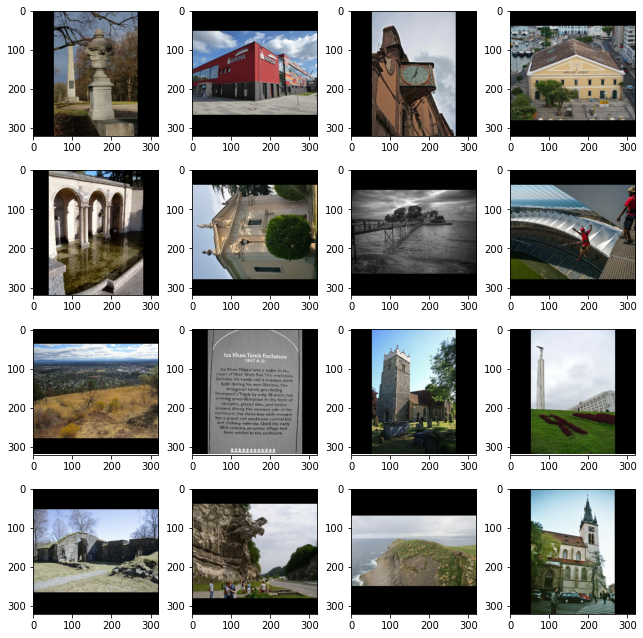

In [3]:
# Testing

_gen = create_dataset(
    dataframe=dataframe, 
    batch_size=config['batch_size'], 
    input_size=config['input_size'], 
    pad_on_resize=config['pad_on_resize'], 
    K=config['K'])


for xs, y in _gen.take(1):
    xs = xs.numpy()
    y = y.numpy()

del _gen

print('input shape  =', xs.shape)
print('output shape =', y.shape)

fig, axes = plt.subplots(4, 4, figsize=(9, 9))

for x, ax in zip(xs, axes.reshape(-1)):
    
    ax.imshow(x)

plt.tight_layout()

In [4]:
class DistributedModel:

    def __init__(self,
                 input_size=(384, 384, 3),
                 n_classes=81313,
                 pretrained_weights=None,
                 finetuned_weights=None,
                 dense_units=2048,
                 dropout_rate=0.5,
                 regularization_factor=1e-5,
                 loss='arcface',
                 scale=30,
                 margin=0.3,
                 optimizer=None,
                 strategy=None,
                 mixed_precision=False,
                 save_best=False):

        self.feature_extractor = create_model(
            input_shape=input_size, 
            n_classes=n_classes,
            pretrained_weights=pretrained_weights,
            dense_units=dense_units,
            dropout_rate=dropout_rate,
            regularization_factor=regularization_factor,
            loss=loss,
            scale=scale,
            margin=margin,)
        self.feature_extractor.build([[None, *input_size], [None,]])
        if finetuned_weights:
            self.feature_extractor.load_weights(finetuned_weights)
        self._initial_weights = self.feature_extractor.get_weights()
        self.mixed_precision = mixed_precision
        self.optimizer = optimizer
        self.strategy = strategy
        self.save_best = save_best
        
        self.loss_metric = tf.keras.metrics.Mean()
        
        if self.optimizer and self.mixed_precision:
            self.optimizer = \
                tf.keras.mixed_precision.experimental.LossScaleOptimizer(
                    optimizer, loss_scale='dynamic')

        if not(os.path.isdir('../output/weights')) and save_best:
            os.makedirs('../output/weights')

    def reset_weights(self):
        self.feature_extractor.set_weights(self._initial_weights)

    def _compute_loss(self, labels, logits):
        per_example_loss = tf.keras.losses.sparse_categorical_crossentropy(
            labels, logits, from_logits=True, axis=-1
        )
        return tf.reduce_mean(per_example_loss) / self.strategy.num_replicas_in_sync

    @tf.function
    def _distributed_train_step(self, dist_inputs):

        def train_step(inputs):
            with tf.GradientTape() as tape:
                logits = self.feature_extractor(inputs, training=True)
                loss = self._compute_loss(inputs[1], logits)
                self.loss_metric.update_state(loss)
                if self.mixed_precision:
                    scaled_loss = self.optimizer.get_scaled_loss(loss)
            if self.mixed_precision:
                scaled_gradients = tape.gradient(
                    scaled_loss, self.feature_extractor.trainable_variables)
                gradients = self.optimizer.get_unscaled_gradients(scaled_gradients)
            else:
                gradients = tape.gradient(loss, self.feature_extractor.trainable_variables)

            self.optimizer.apply_gradients(
                zip(gradients, self.feature_extractor.trainable_variables))
            return loss

        per_replica_loss = self.strategy.run(train_step, args=(dist_inputs,))
        return self.strategy.reduce(
            tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)

    @tf.function
    def _distributed_predict_step(self, dist_inputs):

        def predict_step(inputs):
            features = self.feature_extractor(inputs, training=False)
            return features, inputs[1]

        features, labels = self.strategy.run(predict_step, args=(dist_inputs,))
        if tf.is_tensor(features):
            return [features], [labels]
        else:
            return features.values, labels.values

    def fit(self, ds):

        ds = self.strategy.experimental_distribute_dataset(ds)
        ds = tqdm.tqdm(ds)

        for i, inputs in enumerate(ds):
            loss = self._distributed_train_step(inputs)
            epoch_loss = self.loss_metric.result().numpy()
            ds.set_description(
                "Loss {:.4f}".format(
                    self.loss_metric.result().numpy(),
                )
            )

        self.loss_metric.reset_states()

    def predict(self, ds):

        ds = self.strategy.experimental_distribute_dataset(ds.repeat(1))
        ds = tqdm.tqdm(ds)

        features_accum = np.zeros([0, 1], dtype=np.float32)
        labels_accum = np.zeros([0, 1], dtype=np.float32)

        for inputs in ds:
            features, labels = self._distributed_predict_step(inputs)

            for feats, label in zip(features, labels):
                features_accum = np.concatenate([features_accum, feats.numpy()], axis=0)
                labels_accum = np.concatenate([labels_accum, label.numpy()], axis=0)

        features_accum = features_accum.reshape((1, -1)).mean(axis=0)
        labels_accum = labels_accum.reshape((1, -1)).mean(axis=0).round()

        return features_accum, labels_accum

    def fit_and_predict(self, epochs, train_ds, valid_ds):

        self.score = 0.
        self.best_score = 0.
        for epoch in range(epochs):

            # fit for an epoch
            self.fit(train_ds)
            
            
            
            # predict on validation set
            #valid_features, valid_labels = self.predict(valid_ds)

#             # compute auc score and save model if best_score
#             self.auc_score = metrics.roc_auc_score(valid_trues, valid_preds)
            
#             if self.score > self.best_score:
#                 self.best_score = self.score
#                 best_valid_valid_features = valid_features.copy()
#                 if self.save_best:
#                     self.feature_extractor.save_weights(
#                         f'output/weights/model-{fold}-{epoch}.h5')

            self.feature_extractor.save_weights('../output/weights/model.h5')
        return valid_features, valid_labels


In [ ]:
sss = model_selection.GroupShuffleSplit(
    n_splits=1, test_size=0.2, random_state=42).split(
    X=dataframe.index, 
    y=None,
    groups=dataframe.landmark_id)

# strategy = tf.distribute.MirroredStrategy() # multi-GPU training
strategy = tf.distribute.OneDeviceStrategy(device='GPU') # single-GPU training
# strategy = tf.distribute.OneDeviceStrategy(device='CPU') # CPU training


train_ds = create_dataset(
    dataframe=dataframe, 
    batch_size=config['batch_size'], 
    input_size=config['input_size'], 
    pad_on_resize=config['pad_on_resize'], 
    K=config['K'],
    shuffle_buffer_size=10000)

valid_ds = create_dataset(
    dataframe=dataframe, 
    batch_size=config['batch_size'], 
    input_size=config['input_size'], 
    pad_on_resize=config['pad_on_resize'], 
    K=config['K'])

with strategy.scope():
    
    optimizer = get_optimizer(
        opt=config['optimizer'],
        steps_per_epoch=math.ceil((len(dataframe)*0.8)/config['batch_size']),
        lr_max=config['learning_rate']['max'],
        lr_min=config['learning_rate']['min'],
        warmup_epochs=config['learning_rate']['warmup_epochs'],
        decay_epochs=config['learning_rate']['decay_epochs'],
        power=config['learning_rate']['power'],
    )
    
    dist_model = DistributedModel(
        input_size=config['input_size'],
        n_classes=config['n_classes'],
        pretrained_weights='imagenet',
        finetuned_weights=None,
        dense_units=config['dense_units'],
        dropout_rate=config['dropout_rate'],
        regularization_factor=config['regularization_factor'],
        loss=config['loss']['type'],
        scale=config['loss']['scale'],
        margin=config['loss']['margin'],
        optimizer=optimizer, 
        strategy=strategy,
        mixed_precision=True, 
        save_best=True)
    
    train_idx, valid_idx = next(sss)
        
    valid_features, valid_labels = dist_model.fit_and_predict(
        epochs=config['n_epochs'], 
        train_ds=train_ds, 
        valid_ds=valid_ds, 
    )
